In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

Загрузим данные и создадим датафрейм df

In [17]:
DATASET_PATH = './orders_20190822.csv'

df = pd.read_csv(DATASET_PATH, sep=';')
df.head(3)

,id_o,user_id,price,o_date
0,1234491,337544,"539,000",01.01.2016
1,1234494,171642,"153,300",01.01.2016
2,1234497,260596,"55,300",01.01.2016


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002804 entries, 0 to 2002803
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id_o     int64 
 1   user_id  int64 
 2   price    object
 3   o_date   object
dtypes: int64(2), object(2)
memory usage: 61.1+ MB


In [27]:
df['price'] = df['price'].str.replace(',','.')
df['price'] = pd.to_numeric(df['price'])
df['o_date'] = pd.to_datetime(df['o_date'])
df.head(3)

,id_o,user_id,price,o_date,col_pay
0,1234491,337544,539.0,2016-01-01,2
1,1234494,171642,153.3,2016-01-01,33
2,1234497,260596,55.3,2016-01-01,12


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002804 entries, 0 to 2002803
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   id_o     int64         
 1   user_id  int64         
 2   price    float64       
 3   o_date   datetime64[ns]
 4   col_pay  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 76.4 MB


Количество покупок пользователя

In [29]:
df['col_pay'] = 0
df['col_pay'] = df.groupby('user_id').transform('count')
df.head()

,id_o,user_id,price,o_date,col_pay
0,1234491,337544,539.0,2016-01-01,2
1,1234494,171642,153.3,2016-01-01,33
2,1234497,260596,55.3,2016-01-01,12
3,1234498,1105609,752.5,2016-01-01,1
4,1234500,982696,4410.0,2016-01-01,1


Создадим таблицу с пользователями и отсортируем по id_user

In [30]:
df_user = df.drop_duplicates('user_id')
df_user = df_user.sort_values('user_id')
df_user.drop('id_o', axis=1, inplace=True)
df_user

,user_id,price,o_date,col_pay
759130,0,494.2,2016-08-12,1
3300,1,2799.3,2016-04-01,2
783307,76,1248.1,2016-12-13,2
360540,90,1190.0,2016-07-16,4
198382,91,1073.8,2016-04-20,4
...,...,...,...,...
2002788,5919114,1272.6,2017-12-31,1
2002789,5919118,7242.2,2017-12-31,1
2002790,5919128,886.9,2017-12-31,1
2002800,5919142,4934.3,2017-12-31,1


Вычислим общую стоимость заказа, дату первой и последней покупки

In [31]:
df_user = df_user.merge(df.groupby('user_id')['price'].agg(['sum']), left_on='user_id', right_on=df.groupby('user_id')['price'].agg(['sum']).index)
df_user = df_user.merge(df.groupby('user_id')['o_date'].agg(['max', 'min']), left_on='user_id', right_on=df.groupby('user_id')['o_date'].agg(['max','min']).index)

In [32]:
df_user

,user_id,price,o_date,col_pay,sum,max,min
0,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13
3,90,1190.0,2016-07-16,4,6561.8,2017-12-20,2016-07-16
4,91,1073.8,2016-04-20,4,5413.1,2017-11-10,2016-04-20
...,...,...,...,...,...,...,...
1015114,5919114,1272.6,2017-12-31,1,1272.6,2017-12-31,2017-12-31
1015115,5919118,7242.2,2017-12-31,1,7242.2,2017-12-31,2017-12-31
1015116,5919128,886.9,2017-12-31,1,886.9,2017-12-31,2017-12-31
1015117,5919142,4934.3,2017-12-31,1,4934.3,2017-12-31,2017-12-31


In [62]:
df_user['days'] = (pd.Timestamp('2017-12-31') - df_user['min']).dt.days
df_user['TO'] = df_user['sum'] / df_user['days']
df_user['TO'] = df_user['TO'] * 30
df_user

,user_id,price,o_date,col_pay,sum,max,min,days,TO,R
0,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,506,29.300395,3
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,639,649.981221,3
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13,383,145.958225,3
3,90,1190.0,2016-07-16,4,6561.8,2017-12-20,2016-07-16,533,369.332083,4
4,91,1073.8,2016-04-20,4,5413.1,2017-11-10,2016-04-20,620,261.924194,4
...,...,...,...,...,...,...,...,...,...,...
1015114,5919114,1272.6,2017-12-31,1,1272.6,2017-12-31,2017-12-31,0,inf,4
1015115,5919118,7242.2,2017-12-31,1,7242.2,2017-12-31,2017-12-31,0,inf,4
1015116,5919128,886.9,2017-12-31,1,886.9,2017-12-31,2017-12-31,0,inf,4
1015117,5919142,4934.3,2017-12-31,1,4934.3,2017-12-31,2017-12-31,0,inf,4


In [118]:
df.loc[(df['days'] == 0), 'TO'] = df.loc[(df['days'] == 0)]['sum']

KeyError: 'days'

Определяем критерии для каждой буквы R, F, M

Помотрим, как распределена переменная - последняя дата покупки, то есть max

In [44]:
series = df_user.groupby(df_user['max'].dt.date)['user_id'].count()

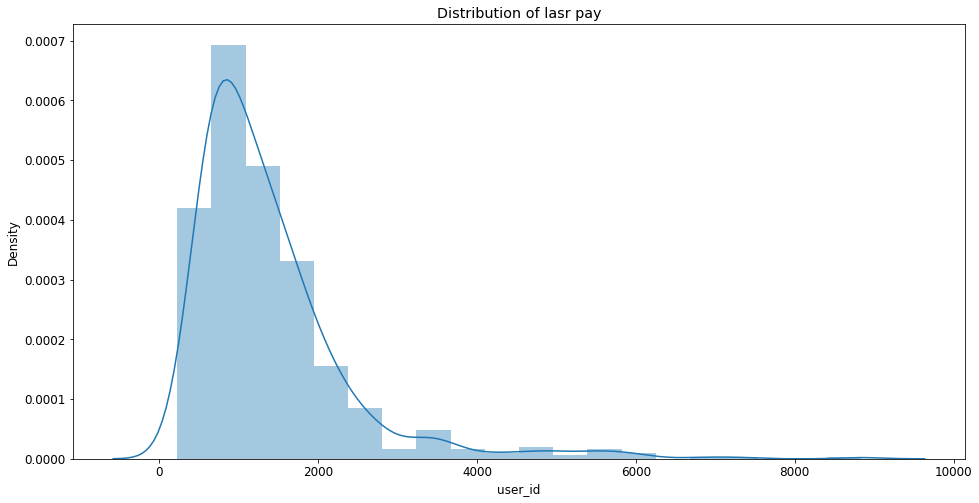

In [47]:
plt.figure(figsize = (16, 8))

sns.distplot(series, bins=20)

y = np.linspace(0, 0.0000075, 10)
plt.title('Distribution of lasr pay')
plt.show()

In [56]:
quant = df_user['max'].quantile([0.25,0.50,0.75], interpolation='nearest') 
quant[0.25]

Timestamp('2016-11-04 00:00:00')

Определим 4 группы пользователей для R:<br>
1 - очень давно не покупающие последняя покупка более 12 месяцев <br>
2 - давно не покупающие последняя покупка 6-12 месяцев назад <br>
3 - покупающие недавно последняя покупка 1-5 месяцев назад <br>

In [155]:
df_user['R'] = 0

df_user.loc[(df_user['max'] <= '2017-01-01'), 'R'] = 1
df_user.loc[(df_user['max'] < '2017-07-31') & (df_user['max'] > '2017-01-01'), 'R'] = 2
df_user.loc[(df_user['max'] >= '2017-07-31'), 'R'] = 3

df_user

,user_id,price,o_date,col_pay,sum,max,min,days,TO,R,F,M,Group
0,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,506,29.300395,1,1,1,0
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,639,649.981221,2,2,4,0
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13,383,145.958225,3,2,3,0
3,90,1190.0,2016-07-16,4,6561.8,2017-12-20,2016-07-16,533,369.332083,3,3,4,0
4,91,1073.8,2016-04-20,4,5413.1,2017-11-10,2016-04-20,620,261.924194,3,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015114,5919114,1272.6,2017-12-31,1,1272.6,2017-12-31,2017-12-31,0,inf,3,1,2,0
1015115,5919118,7242.2,2017-12-31,1,7242.2,2017-12-31,2017-12-31,0,inf,3,1,4,0
1015116,5919128,886.9,2017-12-31,1,886.9,2017-12-31,2017-12-31,0,inf,3,1,1,0
1015117,5919142,4934.3,2017-12-31,1,4934.3,2017-12-31,2017-12-31,0,inf,3,1,4,0


In [156]:
df_user['R'].value_counts()

3    372042
1    360523
2    282554
Name: R, dtype: int64

Посмотритм на распределение количества покупок

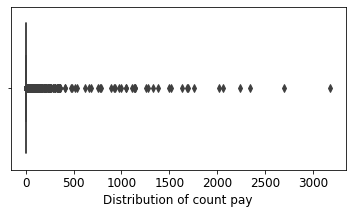

In [84]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_user['col_pay'], whis=1.5)

plt.xlabel('Distribution of count pay')
plt.show()

In [106]:
df_user['col_pay'].value_counts()

1       774497
2       105007
3        42759
4        24046
5        15569
         ...  
163          1
1696         1
155          1
1689         1
1520         1
Name: col_pay, Length: 225, dtype: int64

In [111]:
df_user.loc[df_user['col_pay'] == 2]

,user_id,price,o_date,col_pay,sum,max,min,days,TO,R,F
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,639,649.981221,3,3
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13,383,145.958225,2,3
6,155,6003.2,2016-02-04,2,6745.2,2016-11-04,2016-02-04,696,290.741379,4,3
8,161,13633.2,2016-07-25,2,14697.2,2016-07-26,2016-07-25,524,841.442748,4,3
9,162,9.1,2016-09-08,2,233.1,2016-09-08,2016-09-08,479,14.599165,4,3
...,...,...,...,...,...,...,...,...,...,...,...
1015015,5918331,1045.8,2017-12-31,2,3068.1,2017-12-31,2017-12-31,0,inf,1,3
1015049,5918643,1748.6,2017-12-31,2,2268.0,2017-12-31,2017-12-31,0,inf,1,3
1015095,5919003,3297.7,2017-12-31,2,6793.5,2017-12-31,2017-12-31,0,inf,1,3
1015096,5919008,482.3,2017-12-31,2,949.9,2017-12-31,2017-12-31,0,inf,1,3


Определим 4 группы пользователей для F:<br>
1 - реко покупающие, количество покупок 1 <br>
2 - количество покупок 2-4 <br>
3 - часто покупающие, количество покупок больше или равно 5 <br>

In [165]:
df_user['F'] = 0

df_user.loc[(df_user['col_pay'] >= 5), 'F'] = 3
df_user.loc[(df_user['col_pay'] == 2) | (df_user['col_pay'] == 3)| (df_user['col_pay'] == 4), 'F'] = 2
df_user.loc[(df_user['col_pay'] == 1), 'F'] = 1

df_user

,user_id,price,o_date,col_pay,sum,max,min,days,TO,R,F,M,Group
0,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,506,29.300395,1,1,1,0
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,639,649.981221,2,2,4,0
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13,383,145.958225,3,2,3,0
3,90,1190.0,2016-07-16,4,6561.8,2017-12-20,2016-07-16,533,369.332083,3,2,4,0
4,91,1073.8,2016-04-20,4,5413.1,2017-11-10,2016-04-20,620,261.924194,3,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015114,5919114,1272.6,2017-12-31,1,1272.6,2017-12-31,2017-12-31,0,inf,3,1,2,0
1015115,5919118,7242.2,2017-12-31,1,7242.2,2017-12-31,2017-12-31,0,inf,3,1,4,0
1015116,5919128,886.9,2017-12-31,1,886.9,2017-12-31,2017-12-31,0,inf,3,1,1,0
1015117,5919142,4934.3,2017-12-31,1,4934.3,2017-12-31,2017-12-31,0,inf,3,1,4,0


In [167]:
df_user['F'].value_counts()

1    774497
2    171812
3     68810
Name: F, dtype: int64

Проведем анализ общей суммы покупок

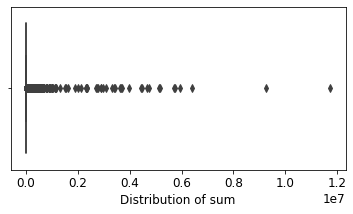

In [168]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_user['sum'], whis=1.5)

plt.xlabel('Distribution of sum')
plt.show()

In [169]:
quant = df_user['sum'].quantile([0.25,0.50,0.75], interpolation='nearest') 
quant

0.25     930.3
0.50    1840.3
0.75    3962.7
Name: sum, dtype: float64

Определим 4 группы пользователей по квантилям для M:
1 - 0,25
2 - 0,25 - 0,50
3 - 0,50 - 0,75
4 - более 0.75

In [170]:
df_user['M'] = 0

df_user.loc[(df_user['sum'] <= quant[0.25]), 'M'] = 1
df_user.loc[(df_user['sum'] > quant[0.25]) & (df_user['sum'] <= quant[0.50]), 'M'] = 2
df_user.loc[(df_user['sum'] > quant[0.50]) & (df_user['sum'] <= quant[0.75]), 'M'] = 3
df_user.loc[(df_user['sum'] > quant[0.75]), 'M'] = 4

df_user

,user_id,price,o_date,col_pay,sum,max,min,days,TO,R,F,M,Group
0,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,506,29.300395,1,1,1,0
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,639,649.981221,2,2,4,0
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13,383,145.958225,3,2,3,0
3,90,1190.0,2016-07-16,4,6561.8,2017-12-20,2016-07-16,533,369.332083,3,2,4,0
4,91,1073.8,2016-04-20,4,5413.1,2017-11-10,2016-04-20,620,261.924194,3,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015114,5919114,1272.6,2017-12-31,1,1272.6,2017-12-31,2017-12-31,0,inf,3,1,2,0
1015115,5919118,7242.2,2017-12-31,1,7242.2,2017-12-31,2017-12-31,0,inf,3,1,4,0
1015116,5919128,886.9,2017-12-31,1,886.9,2017-12-31,2017-12-31,0,inf,3,1,1,0
1015117,5919142,4934.3,2017-12-31,1,4934.3,2017-12-31,2017-12-31,0,inf,3,1,4,0


In [171]:
df_user['M'].value_counts()

1    254148
4    253780
3    253751
2    253440
Name: M, dtype: int64

Введем сегментацию: 333 и 233 – это Vip, 1XX – это Lost, остальные Regular

In [183]:
df_user['Group'] = 0
df_user.loc[(((df_user['R'] == 3) | (df_user['R'] == 2)) & ((df_user['F'] == 3)), 'Group')] = 'Vip'
df_user.loc[(((df_user['R'] == 1)), 'Group')] = 'Lost'
df_user.loc[(((df_user['Group'] == 0)), 'Group')] = 'Regular'

In [194]:
df_user

,user_id,price,o_date,col_pay,sum,max,min,days,TO,R,F,M,Group
0,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,506,29.300395,1,1,1,Lost
1,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,639,649.981221,2,2,4,Regular
2,76,1248.1,2016-12-13,2,1863.4,2017-09-11,2016-12-13,383,145.958225,3,2,3,Regular
3,90,1190.0,2016-07-16,4,6561.8,2017-12-20,2016-07-16,533,369.332083,3,2,4,Regular
4,91,1073.8,2016-04-20,4,5413.1,2017-11-10,2016-04-20,620,261.924194,3,2,4,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015114,5919114,1272.6,2017-12-31,1,1272.6,2017-12-31,2017-12-31,0,inf,3,1,2,Regular
1015115,5919118,7242.2,2017-12-31,1,7242.2,2017-12-31,2017-12-31,0,inf,3,1,4,Regular
1015116,5919128,886.9,2017-12-31,1,886.9,2017-12-31,2017-12-31,0,inf,3,1,1,Regular
1015117,5919142,4934.3,2017-12-31,1,4934.3,2017-12-31,2017-12-31,0,inf,3,1,4,Regular


In [248]:
Group_user = df_user['Group'].value_counts()
Group_user

Regular    593818
Lost       360523
Vip         60778
Name: Group, dtype: int64

Для каждой группы из 'Group' находим кол-во пользователей, которые попали в них и % товарооборота, которое они сделали на эти 2 года.

In [249]:
temp = df_user['TO'].sum()
df_user.loc[(df_user['TO'] == temp), 'TO'] = 0 

In [250]:
TO_all = df_user['TO'].sum()
User_count = df_user['Group'].count()
sum_Group = df_user.groupby('Group')['TO'].agg('sum')
sum_Group.sum()

1175944787.1754642

In [281]:
df_RFM = pd.DataFrame (
    {
        'Count_gr': pd.Series([Group_user.Lost, Group_user.Regular, Group_user.Vip], index = ['Lost', 'Regular','Vip']),
        'Sum_TO': sum_Group,
        'Pr_TO': round((sum_Group * 100) / TO_all, 2),
        'Sum_price': df_user.groupby('Group')['sum'].agg('sum'),
        'Pr_sum_price': round((df_user.groupby('Group')['sum'].agg('sum') * 100) / df_user['sum'].sum(), 2),
    }
)

In [282]:
df_RFM

,Count_gr,Sum_TO,Pr_TO,Sum_price,Pr_sum_price
Lost,360523,5.997634e+07,5.10,1.049922e+09,23.11
Regular,593818,1.012122e+09,86.07,1.923347e+09,42.34
Vip,60778,1.038465e+08,8.83,1.569418e+09,34.55


In [283]:
User_count == df_RFM.sum().Count_gr    

True

In [284]:
df_RFM.sum().Pr_sum_price

100.0